In [1]:
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image, display
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib.path as mpath
import matplotlib.patheffects as PathEffects
from scipy import stats
import scipy
import numpy.ma as ma
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy.ndimage import gaussian_filter

from modules.plotter import make_cmap
# %matplotlib inline

In [2]:
def preprocess(ds):
    '''keep only the selected lats and lons'''
    return ds.sel(latitude=slice(10,50), longitude=slice(210,250))

filename_pattern =  '../data/CFSv2/netcdf_CFSv2_vertical_levels/201*'
ds = xr.open_mfdataset(filename_pattern, engine='netcdf4', preprocess=preprocess)
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
ds.info()

ds size in GB 0.13

xarray.Dataset {
dimensions:
	latitude = 81 ;
	longitude = 81 ;
	p = 37 ;
	time = 9 ;

variables:
	float64 latitude(latitude) ;
		latitude:units = degrees_north ;
		latitude:long_name = latitude ;
	float64 longitude(longitude) ;
		longitude:units = degrees_east ;
		longitude:long_name = longitude ;
	float32 p(p) ;
		p:lev_type = 100 ;
		p:units = mb ;
		p:long_name = p����* ;
	datetime64[ns] time(time) ;
		time:long_name = verification time generated by wgrib2 function verftime() ;
		time:reference_time_type = 1 ;
		time:reference_time_description = analyses, reference date is fixed ;
		time:time_step_setting = auto ;
		time:time_step = 0.0 ;
	float32 prmsl(time, latitude, longitude) ;
		prmsl:short_name = prmsl ;
		prmsl:long_name = Pressure ;
		prmsl:level = mean sea level ;
		prmsl:units = Pa ;
	float32 hgtprs(time, p, latitude, longitude) ;
		hgtprs:short_name = hgtprs ;
		hgtprs:long_name = Geopotential Height ;
		hgtprs:level = ��M ;
		hgtprs:units = m ;
	floa

In [3]:
da_SPFH = ds.spfh.sel(p=slice(1000,300))
da_V = ds.v.sel(p=slice(1000,300))
da_U = ds.u.sel(p=slice(1000,300))
pressure = ds.p.sel(p=slice(1000,300)).values

da_MSL = ds.prmsl
da_MSL = da_MSL/100 # convert to hPa

U_850 = ds.u.sel(p=850.0)* 1.94384 ## convert to knots
V_850 = ds.v.sel(p=850.0)* 1.94384 ## convert to knots

da_GPH = ds.hgtprs.sel(p=500.0)

In [4]:
lats = ds['latitude']
lons = ds['longitude']

In [5]:
g = -9.81 # gravity constant
ivt_u = scipy.integrate.trapz(da_U*da_SPFH, pressure, axis=1)*g
print(ivt_u.shape)
ivt_v = scipy.integrate.trapz(da_V*da_SPFH, pressure, axis=1)*g
print(ivt_v.shape)
ivt_total = np.sqrt(ivt_u**2 + ivt_v**2)

iwv = scipy.integrate.trapz(da_SPFH, pressure, axis=1)*g

(9, 81, 81)
(9, 81, 81)


In [6]:
colors = [(255,255,0), (255, 228, 0), (255, 200, 0), 
          (255, 173, 0), (255, 130, 0), (255, 80, 0),
          (255, 30, 0), (235, 0, 16), (184, 0, 58), 
          (133,0,99), (87,0,136)]
my_cmap = make_cmap(colors, bit=True)

./figures/f2.png


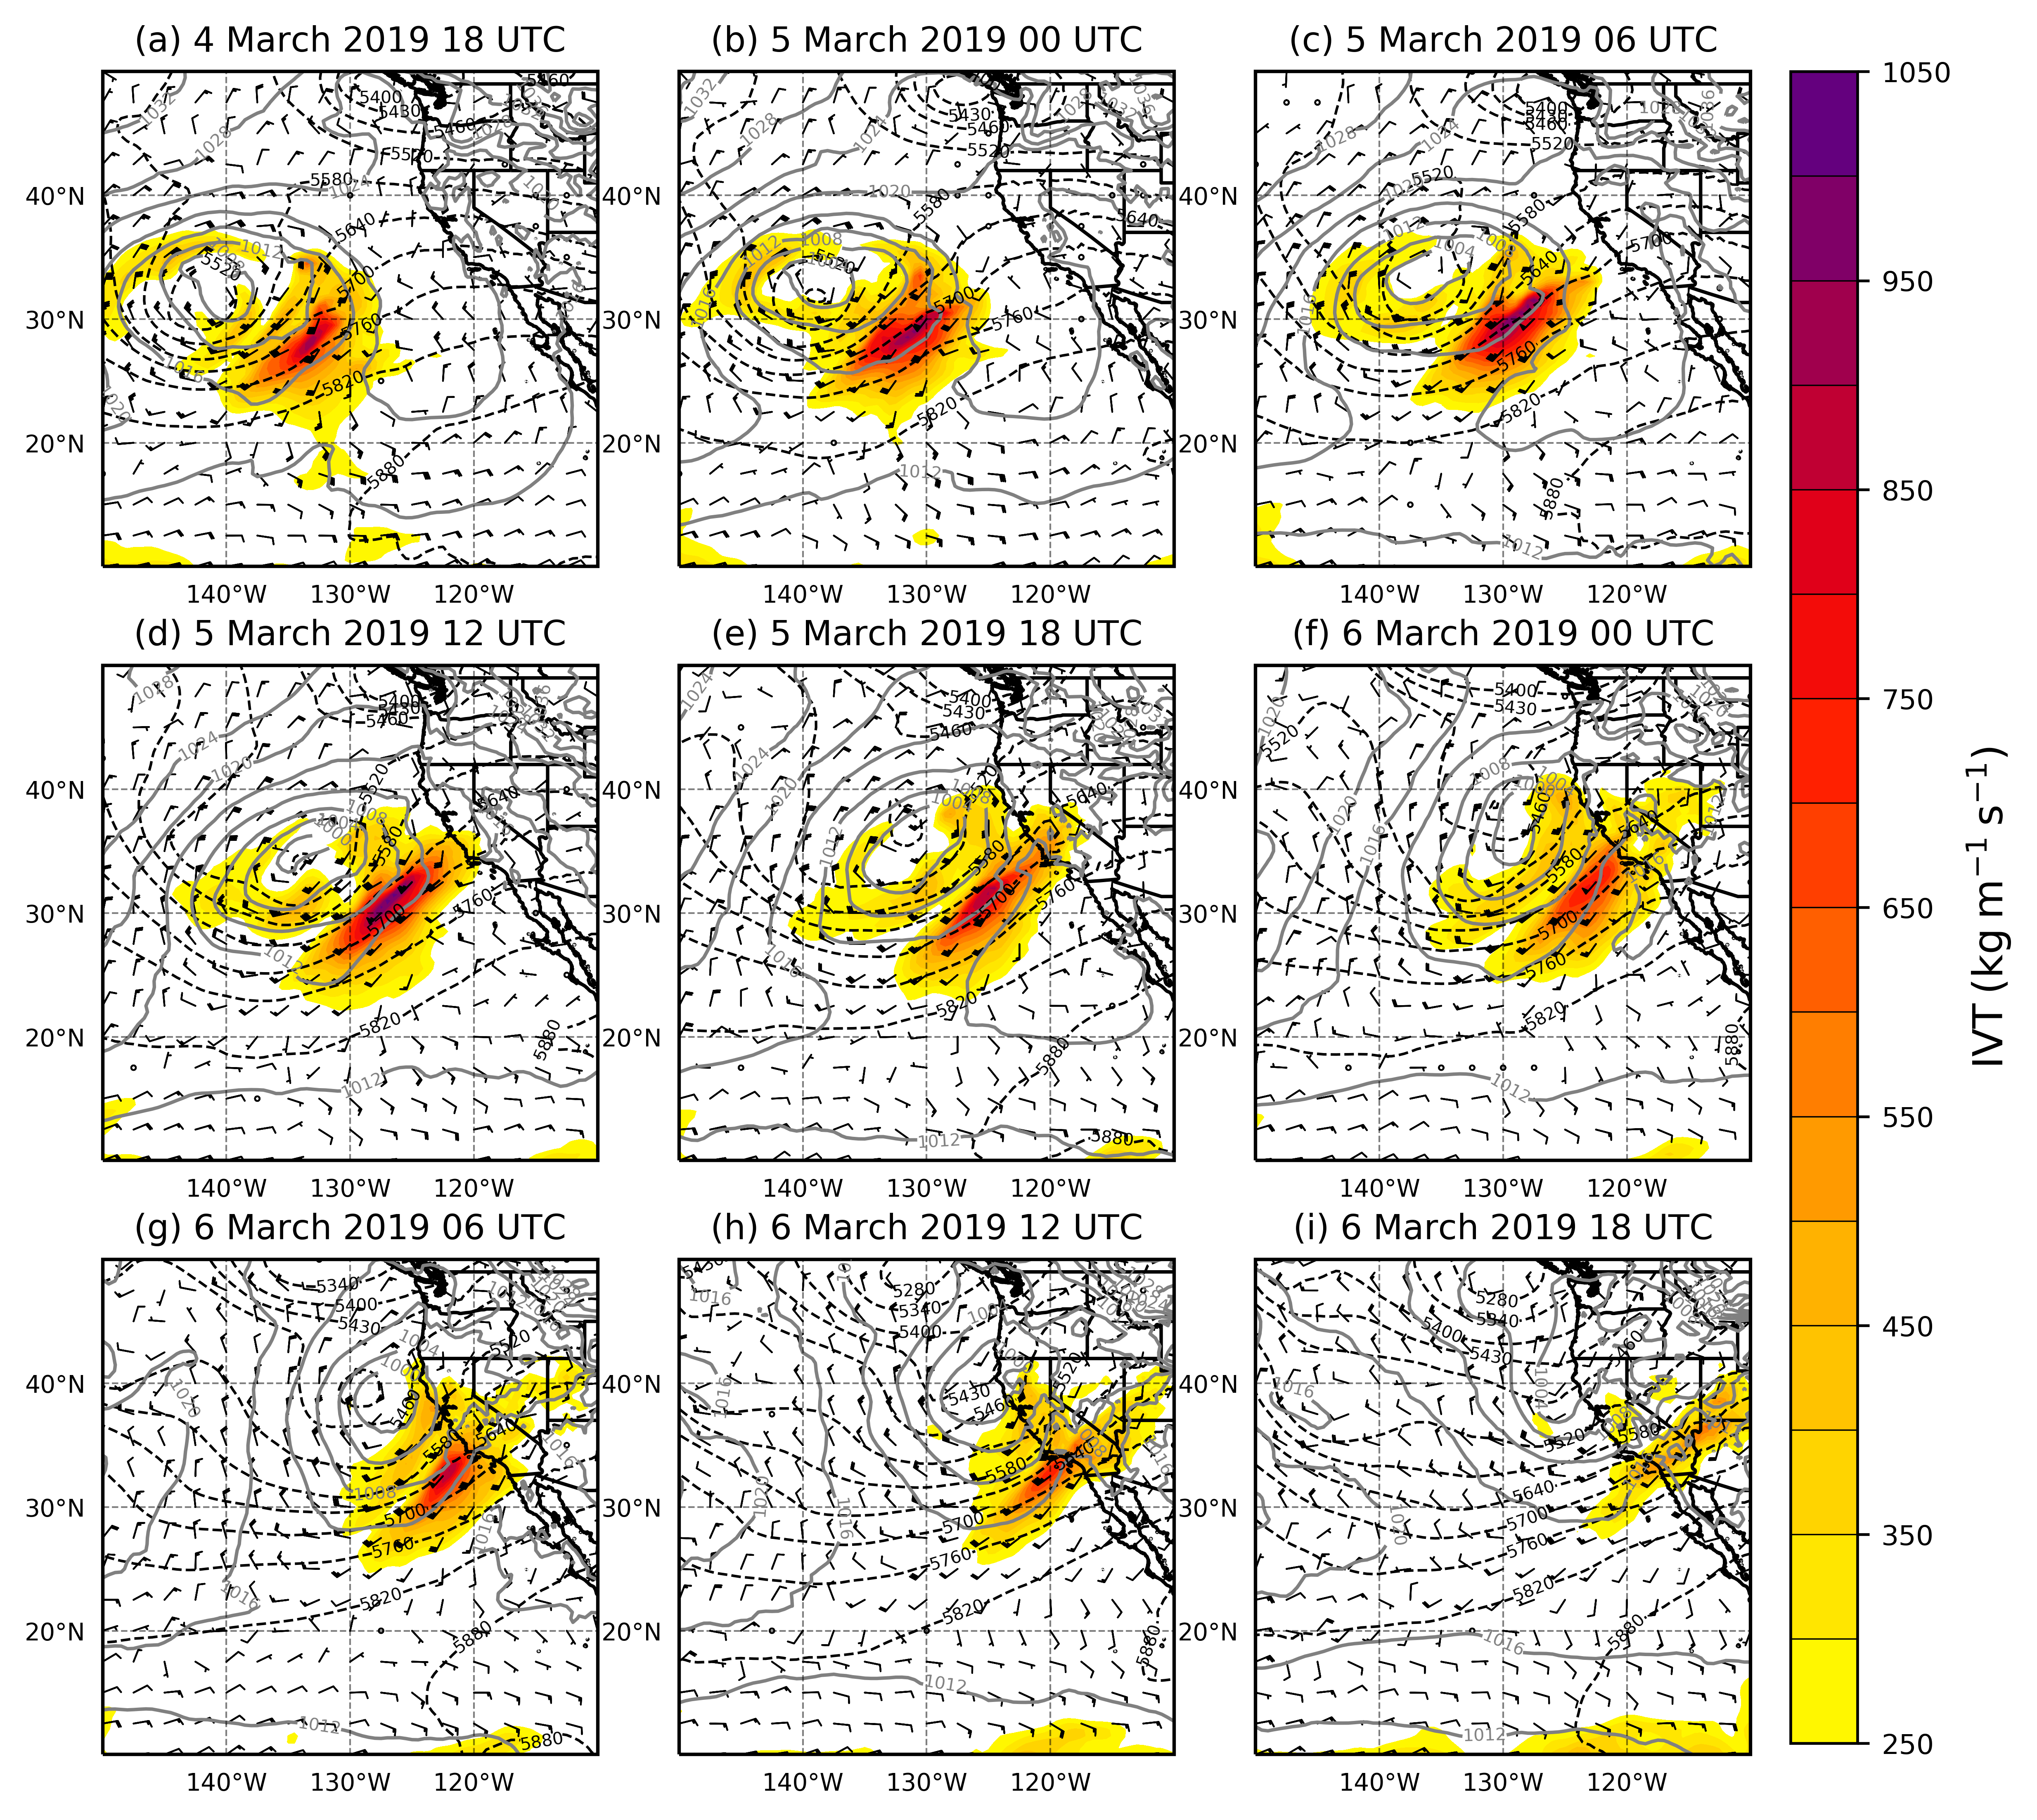

<Figure size 5400x5400 with 0 Axes>

In [14]:
fig = plt.figure(figsize=(9,9))
fig.dpi = 600
fname = './figures/f2'
fmt1 = 'png'
fmt2 = 'pdf'
results = iwv ## convert to cm
subtitles = ['(a) 4 March 2019 18 UTC', 
             '(b) 5 March 2019 00 UTC', '(c) 5 March 2019 06 UTC', '(d) 5 March 2019 12 UTC',
             '(e) 5 March 2019 18 UTC',
            '(f) 6 March 2019 00 UTC', '(g) 6 March 2019 06 UTC', '(h) 6 March 2019 12 UTC',
             '(i) 6 March 2019 18 UTC']

lats = ds['latitude']
lons = ds['longitude']
# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

for i in np.arange(len(results)):
    ax = plt.subplot(3, 3, i+1, projection=ccrs.PlateCarree())
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree())
    
    # Add Border Features
    ax.coastlines(linewidths=1.0, resolution='10m')
    ax.add_feature(states_provinces, edgecolor='k')
    ax.add_feature(cfeature.BORDERS)
    
    # Plot IVT
    ivtclevs = np.arange(250,1100,50)
    cf = ax.contourf(lons, lats, ivt_total[i], transform=datacrs,
                     extend='neither', cmap=my_cmap, levels=ivtclevs)
    
    # Plot winds
    barbx = 5
    barbs = ax.barbs(lons[::barbx], lats[::barbx],
                     U_850[i, ::barbx, ::barbx], V_850[i, ::barbx, ::barbx],
                     length=3, linewidth=0.5)

    # Plot GPH with multiple colors
    kw_clabels = {'fontsize': 5, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
                  'rightside_up': True, 'use_clabeltext': True}
    clevsgph = (np.arange(0, 5430, 60),
         np.array([5430]),
         np.arange(5460, 7000, 60))
    colors = ('tab:blue', 'b', 'tab:red')
    for clevthick, color in zip(clevsgph, colors):
        cs = ax.contour(lons, lats, da_GPH[i,:,:], levels=clevthick, colors='k',
                        linewidths=0.75, linestyles='dashed', transform=datacrs)
        plt.clabel(cs, **kw_clabels)

    # Plot MSLP
    mslp_sm = gaussian_filter(da_MSL[i,:,:], sigma=1.5)
    clevmslp = np.arange(800., 1120., 4)
    cs2 = ax.contour(lons, lats, da_MSL[i,:,:], clevmslp, colors='grey', linewidths=1.,
                     linestyles='solid', transform=datacrs)
    plt.clabel(cs2, **kw_clabels)
    
    
    ax.set_title(subtitles[i], fontsize=10)
    ## Add in meridian and parallels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.5, color='black', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator([-150, -140, -130, -120, -110])
    gl.ylocator = mticker.FixedLocator([10,20, 30, 40, 50])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 7}
    gl.ylabel_style = {'size': 7}

# # add colorbar [left, bottom, width, height]
ax2 = fig.add_axes([0.9, 0.13, 0.03, 0.75])
cbar = fig.colorbar(cf, cax=ax2, drawedges=True, 
                    orientation='vertical', extendfrac='auto')
cbar.ax.tick_params(labelsize=8)
cbar.set_label(r'$\mathrm{IVT \:(kg \:m^{-1} \:s^{-1})}$', fontsize=12)

plt.subplots_adjust(hspace=0.2, wspace=0.003)
# fig.suptitle('CFSv2 IWV (mm; shaded), 850-hPa Wind (barbs), MSLP (hPa, black contours), 500-hPa GPH (m, red contours)')

fig.savefig('%s.%s' %(fname, fmt1), bbox_inches='tight', dpi=fig.dpi)
fig.savefig('%s.%s' %(fname, fmt2), bbox_inches='tight', dpi=fig.dpi)
fig.clf()


plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

In [9]:
for i in np.arange(9):
    print(ivt_total[i].max())

951.59595
989.01355
1003.56256
1034.108
928.96704
761.2505
906.7283
735.18646
629.3228


In [10]:
for i in np.arange(8):
    print(iwv[i].max())

47.74135
48.157047
46.576893
43.86272
44.33777
43.028385
43.703304
44.728203
